<a href="https://colab.research.google.com/github/microprediction/timemachines/blob/main/examples/notebooks/CompareToNaive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timemachines
!pip install --upgrade statsmodels

# Example of comparing against naive forecast
For a given univariate time-series y, this runs checks against some time-series models in the timemachines library and reports any that beat the naive forecast. We proceed from models that can generate forecasts quickly to others that are more painful. First a quick plot...

In [5]:
import numpy as np 
import pandas as pd
y_org = np.cumsum(np.random.randn(1000)) # <--- Swap this out for your time series 



In [11]:
#try and load in m4 hourly tsf
import data_loader as dl

dataDir = '../data/'
m4name = 'm4_hourly_dataset.tsf'
#rawData = pd.read_csv(dataDir+m4name, sep='\t')

loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = dl.convert_tsf_to_dataframe(dataDir+m4name)

print(loaded_data)
print(frequency)
print(forecast_horizon)
print(contain_missing_values)
print(contain_equal_length)



    series_name     start_timestamp  \
0            T1 2015-07-01 12:00:00   
1            T2 2015-07-01 12:00:00   
2            T3 2015-07-01 12:00:00   
3            T4 2015-07-01 12:00:00   
4            T5 2015-07-01 12:00:00   
..          ...                 ...   
409        T410 2017-01-01 12:00:00   
410        T411 2017-01-01 12:00:00   
411        T412 2017-01-01 12:00:00   
412        T413 2017-06-12 12:00:00   
413        T414 2017-04-27 12:00:00   

                                          series_value  
0    [605.0, 586.0, 586.0, 559.0, 511.0, 443.0, 422...  
1    [3124.0, 2990.0, 2862.0, 2809.0, 2544.0, 2201....  
2    [1828.0, 1806.0, 1897.0, 1750.0, 1679.0, 1620....  
3    [6454.0, 6324.0, 6075.0, 5949.0, 5858.0, 5579....  
4    [4263.0, 4297.0, 4236.0, 4080.0, 3883.0, 3672....  
..                                                 ...  
409  [153.0, 196.0, 163.0, 131.0, 82.0, 53.0, 57.0,...  
410  [24.0, 30.0, 22.0, 14.0, 19.0, 20.0, 24.0, 45....  
411  [19.0, 30.0, 

In [3]:
#try and load in m4 daily tsf
import data_loader as dl

dataDir = '../../../../data/'
m4name_d = 'm4_daily_dataset.tsf'
#rawData = pd.read_csv(dataDir+m4name, sep='\t')

loaded_data_d, frequency_d, forecast_horizon_d, contain_missing_values_d, contain_equal_length_d = dl.convert_tsf_to_dataframe(dataDir+m4name_d)

print(loaded_data_d)
print(frequency_d)
print(forecast_horizon_d)
print(contain_missing_values_d)
print(contain_equal_length_d)

     series_name     start_timestamp  \
0             T1 1994-01-03 12:00:00   
1             T2 1995-01-02 12:00:00   
2             T3 2006-01-05 12:00:00   
3             T4 1996-05-30 12:00:00   
4             T5 1997-01-03 12:00:00   
...          ...                 ...   
4222       T4223 2016-07-28 12:00:00   
4223       T4224 2016-07-28 12:00:00   
4224       T4225 2016-09-14 12:00:00   
4225       T4226 2000-01-03 12:00:00   
4226       T4227 2000-01-03 12:00:00   

                                           series_value  
0     [1017.1, 1019.3, 1017.0, 1019.2, 1018.7, 1015....  
1     [2793.7, 2793.8, 2803.7, 2805.8, 2802.3, 2795....  
2     [1091.3, 1088.5, 1085.7, 1082.9, 1080.1, 1077....  
3     [1092.0, 1078.0, 1064.0, 1050.0, 1036.0, 1022....  
4     [2938.63, 2956.44, 2964.41, 2972.41, 3014.97, ...  
...                                                 ...  
4222  [10000.0, 3230.0, 3238.0, 3234.0, 3225.0, 3209...  
4223  [10000.0, 3997.0, 4000.0, 3973.0, 3963.0, 3984...

In [5]:
y = loaded_data_d.series_value[4226].to_numpy()
#print(y_org[0:10])
print(y[0:10])


[4159.1 4138.8 4121.8 4126.7 4127.3 4118.3 4110.7 4097.7 4061.7 4029.9]


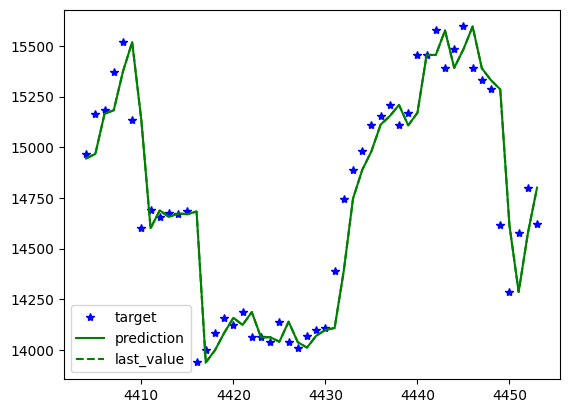

In [6]:
from timemachines.skatertools.visualization.priorplot import prior_plot
import matplotlib.pyplot as plt
from timemachines.skaters.simple.movingaverage import EMA_SKATERS

# Plot an example
f = EMA_SKATERS[0]
k = 1 
prior_plot(f=f, k=k, y=y, n=450, n_plot=50)
plt.show()

In [7]:
threshold = 0.95     # What constitutes an interesting error, relative to naive
from pprint import pprint
from timemachines.skatertools.evaluation.evaluators import evaluate_mean_squared_error_with_sporadic_fit
from timemachines.skaters.simple.movingaverage import empirical_last_value

def report(y,k=1,models=EMA_SKATERS,n_burn=25, threshold=0.98):
  """
       k         - how many step to foreast ahead
       threshold - fraction of naive forecast error that would constitute an interesting finding
       n_burn    - number of points to toss prior to error evaluation, to allow model to warm up
  """
  #lv_err = evaluate_mean_squared_error(f=empirical_last_value, y=y, k=k, a=None, t=None, e=None, r=None, n_burn=n_burn)
  lv_err = evaluate_mean_squared_error_with_sporadic_fit(f=empirical_last_value, y=y, k=k, a=None, t=None, e_fit=None, r=None, n_test=n_burn)
  interesting = dict()
  for f in models:
      #err = evaluate_mean_squared_error_with_sporadic_fit(f=f, y=y, k=1, a=None, t=None, e=None, r=None, n_burn=25)
      err = evaluate_mean_squared_error_with_sporadic_fit(f=f, y=y, k=1, a=None, t=None, e_fit=None, r=None, n_test=25)
      if err<threshold*lv_err:
        print(f.__name__+' error is '+str(err)+" versus "+str(lv_err)+' for naive forecast ')
        interesting[f.__name__] = err 
  return interesting


def print_models(models):
    
    for model in models:
        print(model.__name__)



# Fast models....

In [8]:
from timemachines.skaters.simple.thinking import THINKING_SKATERS
from timemachines.skaters.simple.hypocraticensemble import HYPOCRATIC_ENSEMBLE_SKATERS
FAST_MODELS = EMA_SKATERS + THINKING_SKATERS+HYPOCRATIC_ENSEMBLE_SKATERS
report(y=y,k=k,models=EMA_SKATERS + THINKING_SKATERS+HYPOCRATIC_ENSEMBLE_SKATERS)

{}

# Slow models

In [ ]:
from timemachines.skaters.tsa.alltsaskaters import TSA_SKATERS # might also consider DLM
SLOW_MODELS = TSA_SKATERS
report(y=y,k=k,models=SLOW_MODELS)

/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


tsa_p2_d0_q0 error is 46774.434637551516 versus 47853.10879999999 for naive forecast 


/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


tsa_p1_d0_q1 error is 46841.0802365072 versus 47853.10879999999 for naive forecast 


/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


# Interminable models
This is here really to make the point that some models are intended for one-off forecasting on a historical data set. Don't hold your breath waiting for this to run. 

In [39]:
from timemachines.skaters.proph.prophskaterssingular import fbprophet_univariate
from timemachines.skaters.nproph.nprophetskaters import NPROPHET_UNIVARIATE_SKATERS
INTERMINABLE_MODELS = [fbprophet_univariate] + NPROPHET_UNIVARIATE_SKATERS
#report(y=y,k=k,models=INTERMINABLE_MODELS)
print_models(INTERMINABLE_MODELS)

fbprophet_univariate
nprophet_p1
nprophet_p2
nprophet_p3
nprophet_p5
nprophet_p8


## Try prophet

In [43]:
from timemachines.skaters.proph.prophskaterssingular import fbprophet_univariate
#from timemachines.skaters.nproph.nprophetskaters import NPROPHET_UNIVARIATE_SKATERS
PROPHET_MODELS = [fbprophet_univariate]
print_models(PROPHET_MODELS)
report(y=y,k=k,models=PROPHET_MODELS)

fbprophet_univariate
fbprophet_univariate error is 1007.450221892699 versus 1560.0 for naive forecast 


{'fbprophet_univariate': 1007.450221892699}

In [44]:
from timemachines.skaters.proph.allprophetskaters import PROPHET_SKATERS
#from timemachines.skaters.nproph.nprophetskaters import NPROPHET_UNIVARIATE_SKATERS
#PROPHET_MODELS = [fbprophet_univariate]
print_models(PROPHET_SKATERS)
report(y=y,k=k,models=PROPHET_SKATERS)

fbprophet_exogenous
fbprophet_known
fbprophet_univariate
fbprophet_recursive
fbprophet_cautious
fbprophet_exogenous_hypocratic
fbprophet_univariate_hypocratic
fbprophet_cautious_hypocratic
fbprophet_exogenous_exogenous
fbprophet_univariate_univariate_hypocratic
fbprophet_exogenous error is 1007.450221892699 versus 1560.0 for naive forecast 
fbprophet_known error is 1007.450221892699 versus 1560.0 for naive forecast 
fbprophet_univariate error is 1007.450221892699 versus 1560.0 for naive forecast 
fbprophet_recursive error is 1007.450221892699 versus 1560.0 for naive forecast 
fbprophet_cautious error is 959.7962285216222 versus 1560.0 for naive forecast 
fbprophet_exogenous_hypocratic error is 794.803742577559 versus 1560.0 for naive forecast 
fbprophet_univariate_hypocratic error is 794.803742577559 versus 1560.0 for naive forecast 
fbprophet_cautious_hypocratic error is 800.2872097180681 versus 1560.0 for naive forecast 
fbprophet_univariate_univariate_hypocratic error is 1520.436136

{'fbprophet_exogenous': 1007.450221892699,
 'fbprophet_known': 1007.450221892699,
 'fbprophet_univariate': 1007.450221892699,
 'fbprophet_recursive': 1007.450221892699,
 'fbprophet_cautious': 959.7962285216222,
 'fbprophet_exogenous_hypocratic': 794.803742577559,
 'fbprophet_univariate_hypocratic': 794.803742577559,
 'fbprophet_cautious_hypocratic': 800.2872097180681,
 'fbprophet_univariate_univariate_hypocratic': 1520.4361362495265}